In [1]:
from os.path import dirname, join, abspath
import numpy as np
import time
import cv2
from numpy import random

from pathlib import Path
import os,sys
import os.path

from skimage import io
from skimage.transform import resize
import skimage.color
from skimage.util import img_as_ubyte

from deeplabcut import DEBUG
from deeplabcut.utils import auxiliaryfunctions, conversioncode, auxfun_models, visualization
from deeplabcut.pose_estimation_tensorflow import training
from deeplabcut.pose_estimation_tensorflow.nnet import predict as ptf_predict
from deeplabcut.pose_estimation_tensorflow.config import load_config
from deeplabcut.pose_estimation_tensorflow.dataset.pose_dataset import data_to_input
import tensorflow as tf


class Keypoint_detector:
    def __init__(self, weights_path, config):

        self.weights_path = weights_path
        self.config = config

        gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.6)
        sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

        gputouse = None
        use_gpu = False


        # Suppress scientific notation while printing
        np.set_printoptions(suppress=True)

        ##################################################
        # SETUP everything until image prediction
        ##################################################

        if 'TF_CUDNN_USE_AUTOTUNE' in os.environ:
            del os.environ['TF_CUDNN_USE_AUTOTUNE']  # was potentially set during training

        vers = tf.__version__.split('.')
        if int(vers[0]) == 1 and int(vers[1]) > 12:
            TF = tf.compat.v1
        else:
            TF = tf

        TF.reset_default_graph()

        os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
        #tf.logging.set_verbosity(tf.logging.WARN)

        start_path = os.getcwd()

        # Read file path for pose_config file. >> pass it on
        if gputouse is not None:  # gpu selectinon
            os.environ['CUDA_VISIBLE_DEVICES'] = str(gputouse)

        ##################################################
        # Load and setup CNN part detector
        ##################################################

        path_test_config = self.config

        try:
            self.dlc_cfg = load_config(str(path_test_config))
        except FileNotFoundError:
            raise FileNotFoundError(
                "It seems the model for shuffle s and trainFraction %s does not exist.")

        self.dlc_cfg['init_weights'] = self.weights_path
        print("Running the weights: " + self.dlc_cfg['init_weights'])


        # Using GPU for prediction
        # Specifying state of model (snapshot / training state)
        if use_gpu:
            self.sess, self.inputs, self.outputs = ptf_predict.setup_GPUpose_prediction(self.dlc_cfg)
            self.pose_tensor = ptf_predict.extract_GPUprediction(self.outputs, self.dlc_cfg)
        else:
            self.sess, self.inputs, self.outputs = ptf_predict.setup_pose_prediction(self.dlc_cfg)


    def predict_single_image(self, image):
        """
        Returns pose for one single image
        :param image:
        :return:
        """
        # The size here should be the size of the images on which your CNN was trained on
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = img_as_ubyte(image)
        pose = ptf_predict.getpose(image, self.dlc_cfg, self.sess, self.inputs, self.outputs)
        return pose



    def overwrite_image(self, image, points_predicted,scores):

        # TODO: Separate this to another function
        height, width = image.shape[:2]

        #Clipping points so that they don't fall outside the image size
        #points_predicted[:,0] = points_predicted[:,0].clip(0, height-1)
        #points_predicted[:,1] = points_predicted[:,1].clip(0, width-1)

        points_predicted = points_predicted.astype(int)

        # Printing as a circle
        for i in range(len(points_predicted)):
            #print(points)
            if scores[i] > 0.0:
                points = points_predicted[i]
                image = cv2.circle(image,tuple(points), 5, (0,255,0), -1)
                
                #image = cv2.putText(image, str(i) + " " + str(round(scores[i],2)), tuple(points), cv2.FONT_HERSHEY_SIMPLEX,0.2, (0,0,255), 1, cv2.LINE_AA)  
        return image




ModuleNotFoundError: No module named 'deeplabcut'

In [2]:
kp_detector = Keypoint_detector(weights_path="model/snapshot-860000", 
                                config="pose_cfg.yaml")

Running the weights: model/snapshot-860000
Initializing ResNet
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Use standard file APIs to check for files with this prefix.


Instructions for updating:
Use standard file APIs to check for files with this prefix.


INFO:tensorflow:Restoring parameters from model/snapshot-860000


INFO:tensorflow:Restoring parameters from model/snapshot-860000


In [3]:
file_name = "/home/jingpei/Desktop/rope_data/dlc_test/1632346676444013354.png"
img = cv2.imread(file_name)
imgScale = 1.0
newX,newY = img.shape[1]*imgScale, img.shape[0]*imgScale
resized_img = cv2.resize(img,(int(newX),int(newY)))

results = kp_detector.predict_single_image(resized_img)
points_predicted = results[:,:2] * 1
points_predicted = points_predicted.astype(int)
scores = results[:,2]
img = kp_detector.overwrite_image(img, points_predicted, scores)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

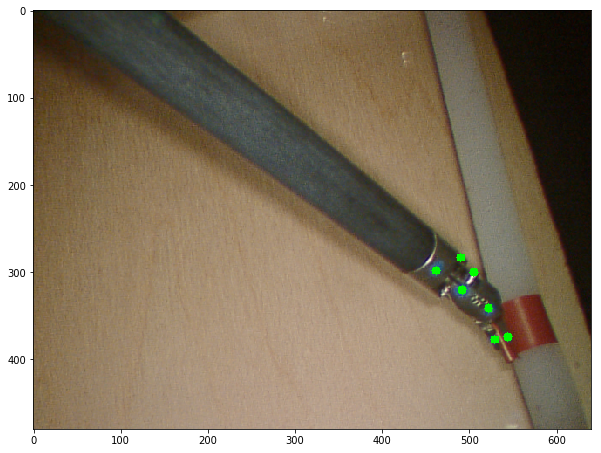

In [4]:
import matplotlib.pyplot as plt

%matplotlib inline  
plt.figure(figsize = (10,10))
plt.imshow(img)

In [7]:
import glob
filenames = glob.glob("/home/jingpei/Desktop/rope_data/dlc_test/*.png")
filenames.sort(key=lambda f:int(f.split("/")[-1].split(".")[-2]))

In [10]:
for i in range(len(filenames)):
    file_name = filenames[i]
    img = cv2.imread(file_name)
    imgScale = 1.0
    newX,newY = img.shape[1]*imgScale, img.shape[0]*imgScale
    resized_img = cv2.resize(img,(int(newX),int(newY)))

    results = kp_detector.predict_single_image(resized_img)
    points_predicted = results[:,:2] * 1
    points_predicted = points_predicted.astype(int)
    scores = results[:,2]
    img = kp_detector.overwrite_image(img, points_predicted, scores)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imsave("/home/jingpei/Desktop/rope_data/dlc_test/results/" + str(i) + ".png",img)
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27